In [22]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

In [23]:
df_scraping = pd.read_csv('filtered_data.csv')
df_scraping.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4513 entries, 0 to 4512
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   url            4513 non-null   object 
 1   date           4513 non-null   object 
 2   article        4513 non-null   object 
 3   standard_date  4513 non-null   object 
 4   title          4513 non-null   object 
 5   address        4513 non-null   object 
 6   coordinates    4465 non-null   object 
 7   lat            4465 non-null   float64
 8   lon            4465 non-null   float64
 9   alcaldia       4513 non-null   object 
dtypes: float64(2), object(8)
memory usage: 352.7+ KB


In [24]:
# remove none rows
df_scraping = df_scraping.dropna()

In [25]:
# Step 2: Convert 'date' column to datetime
df_scraping['date'] = pd.to_datetime(df_scraping['standard_date'])

# Step 3: Extract year and month from 'date'
df_scraping['year'] = df_scraping['date'].dt.year
df_scraping['month'] = df_scraping['date'].dt.month

# Step 4: Create geometry column from longitude and latitude
df_scraping['geometry'] = df_scraping.apply(lambda row: Point(row['lon'], row['lat']), axis=1)

# Step 5: Convert DataFrame to GeoDataFrame
gdf_scraping = gpd.GeoDataFrame(df_scraping, geometry='geometry')

# Step 6: Set coordinate reference system to WGS84
gdf_scraping.set_crs(epsg=4326, inplace=True)

# Optional: Read Mexico City shapefile for map overlay (if available)
city_map = gpd.read_file('poligonos_alcaldias_cdmx')

In [26]:
gdf_scraping = gpd.clip(gdf_scraping, city_map)
gdf_scraping.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 3761 entries, 1554 to 1331
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   url            3761 non-null   object        
 1   date           3761 non-null   datetime64[ns]
 2   article        3761 non-null   object        
 3   standard_date  3761 non-null   object        
 4   title          3761 non-null   object        
 5   address        3761 non-null   object        
 6   coordinates    3761 non-null   object        
 7   lat            3761 non-null   float64       
 8   lon            3761 non-null   float64       
 9   alcaldia       3761 non-null   object        
 10  year           3761 non-null   int32         
 11  month          3761 non-null   int32         
 12  geometry       3761 non-null   geometry      
dtypes: datetime64[ns](1), float64(2), geometry(1), int32(2), object(7)
memory usage: 382.0+ KB


In [27]:
gdf_scraping = gpd.clip(gdf_scraping, city_map)
gdf_scraping.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 3761 entries, 88 to 2423
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   url            3761 non-null   object        
 1   date           3761 non-null   datetime64[ns]
 2   article        3761 non-null   object        
 3   standard_date  3761 non-null   object        
 4   title          3761 non-null   object        
 5   address        3761 non-null   object        
 6   coordinates    3761 non-null   object        
 7   lat            3761 non-null   float64       
 8   lon            3761 non-null   float64       
 9   alcaldia       3761 non-null   object        
 10  year           3761 non-null   int32         
 11  month          3761 non-null   int32         
 12  geometry       3761 non-null   geometry      
dtypes: datetime64[ns](1), float64(2), geometry(1), int32(2), object(7)
memory usage: 382.0+ KB


In [28]:
start_date = pd.to_datetime('2019-02-01')
end_date = pd.to_datetime('2024-11-01')
gdf_scraping = gdf_scraping[(gdf_scraping['date'] >= start_date) & (gdf_scraping['date'] < end_date)]
gdf_scraping.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 3597 entries, 88 to 2423
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   url            3597 non-null   object        
 1   date           3597 non-null   datetime64[ns]
 2   article        3597 non-null   object        
 3   standard_date  3597 non-null   object        
 4   title          3597 non-null   object        
 5   address        3597 non-null   object        
 6   coordinates    3597 non-null   object        
 7   lat            3597 non-null   float64       
 8   lon            3597 non-null   float64       
 9   alcaldia       3597 non-null   object        
 10  year           3597 non-null   int32         
 11  month          3597 non-null   int32         
 12  geometry       3597 non-null   geometry      
dtypes: datetime64[ns](1), float64(2), geometry(1), int32(2), object(7)
memory usage: 365.3+ KB


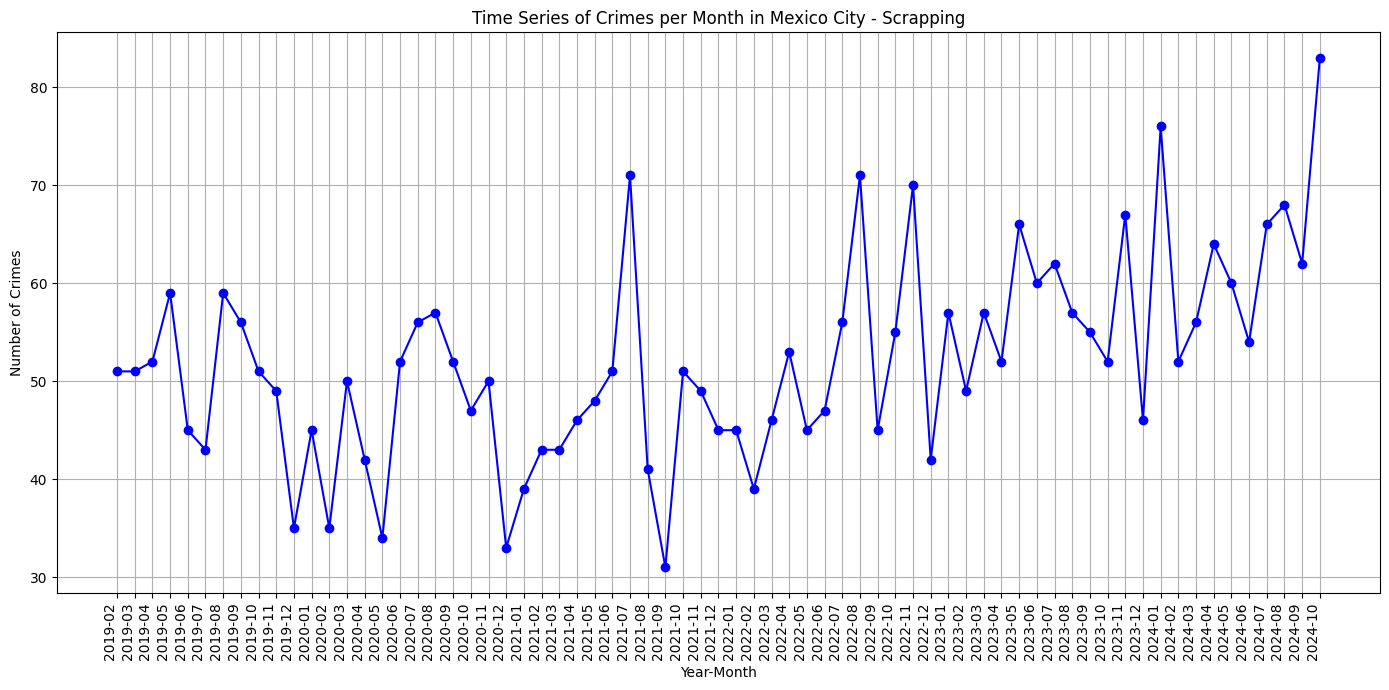

In [29]:
def plot_time_series_crimes_per_month(gdf):
    # Group data by year and month, then count the number of crimes
    gdf['year_month'] = gdf['date'].dt.to_period('M')  # Create a year-month period column
    crime_counts_per_month = gdf.groupby('year_month').size().reset_index(name='crime_count')
    crime_counts_per_month['year_month'] = crime_counts_per_month['year_month'].astype(str)  # Convert to string for plotting

    # Plot the time series
    plt.figure(figsize=(14, 7))
    plt.plot(crime_counts_per_month['year_month'], crime_counts_per_month['crime_count'], marker='o', linestyle='-', color='blue')
    plt.title('Time Series of Crimes per Month in Mexico City - Scrapping')
    plt.xlabel('Year-Month')
    plt.ylabel('Number of Crimes')
    plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better readability
    plt.grid(True)
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()

# Example usage:
plot_time_series_crimes_per_month(gdf_scraping)

/home/christian/taller/scrapy-nlp-crime-cdmx/.venv_2/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/tmp/ipykernel_37167/58631900.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  crime_counts_

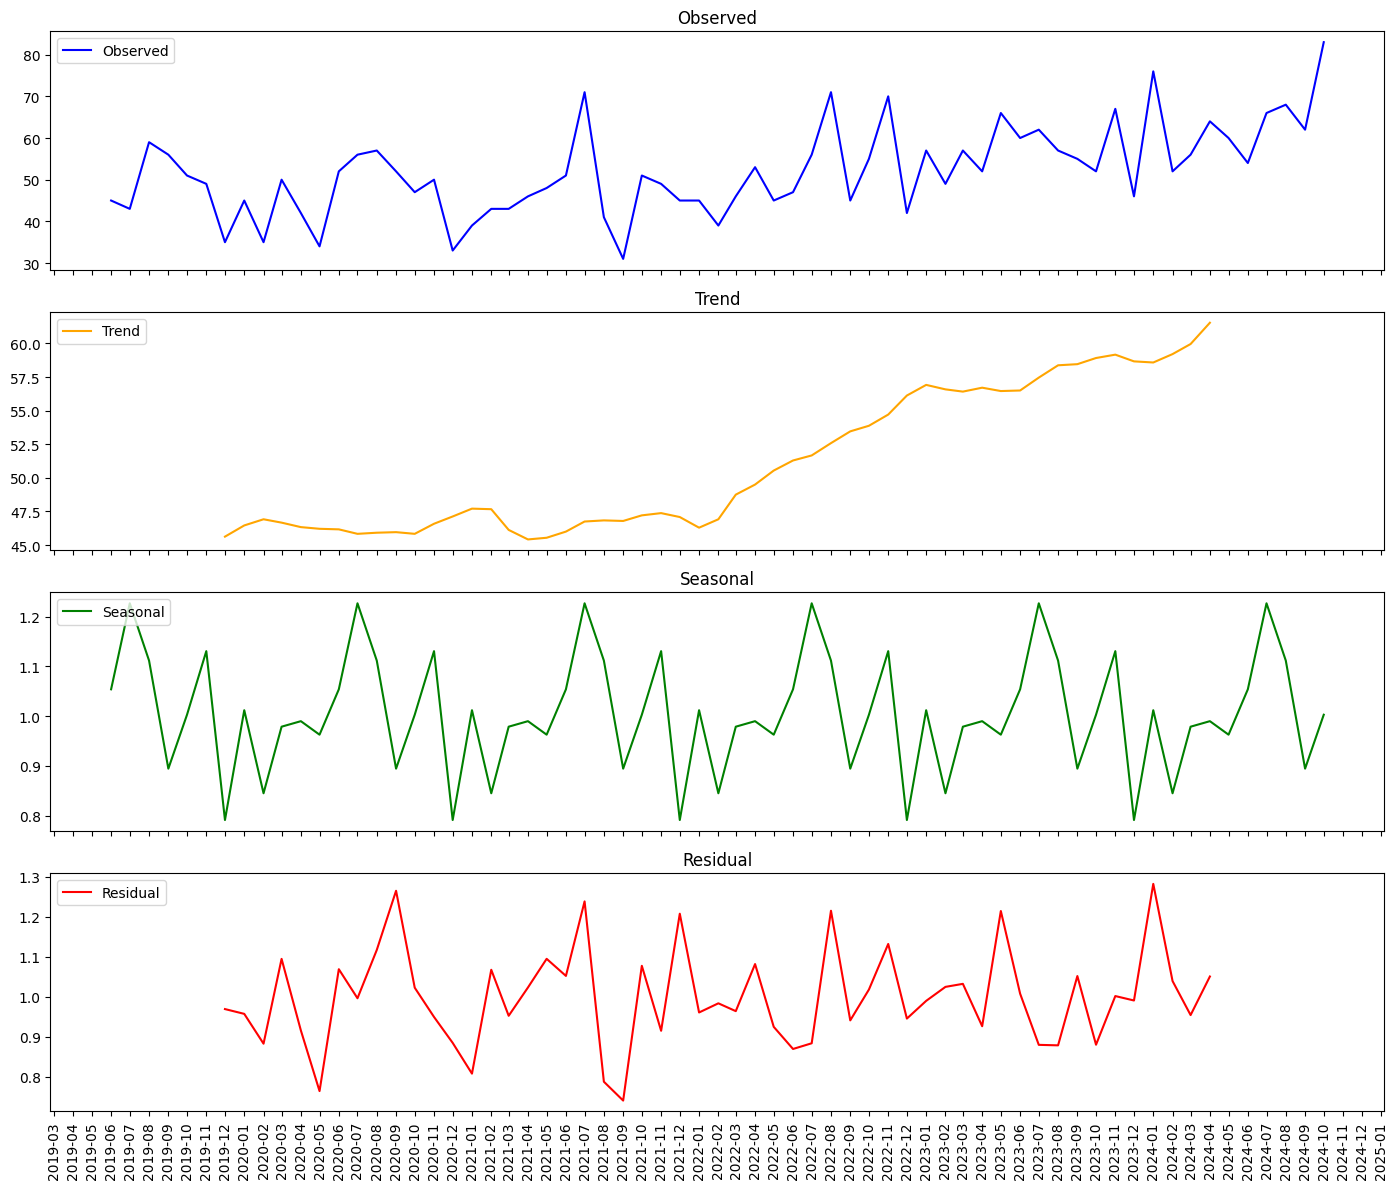

In [30]:
def analyze_time_series_crimes_per_month(gdf):
    # **Filter data to include dates from June 2019 onwards**
    start_date = pd.to_datetime('2019-06-01')
    end_date = pd.to_datetime('2024-11-01')
    gdf_filtered = gdf[(gdf['date'] >= start_date) & (gdf['date'] < end_date)]
   

    # Group data by year and month, then count the number of crimes
    gdf_filtered['year_month'] = gdf_filtered['date'].dt.to_period('M')  # Create a year-month period column
    crime_counts_per_month = gdf_filtered.groupby('year_month').size().reset_index(name='crime_count')

    # Set 'year_month' as the index
    crime_counts_per_month.set_index('year_month', inplace=True)

    # Ensure the index has a frequency
    crime_counts_per_month.index = crime_counts_per_month.index.to_timestamp()
    crime_counts_per_month = crime_counts_per_month.asfreq('MS')  # 'MS' stands for Month Start

    # Handle missing data by interpolating
    crime_counts_per_month['crime_count'].interpolate(method='linear', inplace=True)

    # Perform seasonal decomposition
    result = seasonal_decompose(crime_counts_per_month['crime_count'], model='multiplicative')

    # Extract the components
    observed = result.observed
    trend = result.trend
    seasonal = result.seasonal
    residual = result.resid

    # Create a figure with four subplots
    fig, axs = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

    # Plot observed data
    axs[0].plot(crime_counts_per_month.index, observed, label='Observed', color='blue')
    axs[0].set_title('Observed')
    axs[0].legend(loc='upper left')

    # Plot trend component
    axs[1].plot(crime_counts_per_month.index, trend, label='Trend', color='orange')
    axs[1].set_title('Trend')
    axs[1].legend(loc='upper left')

    # Plot seasonal component
    axs[2].plot(crime_counts_per_month.index, seasonal, label='Seasonal', color='green')
    axs[2].set_title('Seasonal')
    axs[2].legend(loc='upper left')

    # Plot residuals
    axs[3].plot(crime_counts_per_month.index, residual, label='Residual', color='red')
    axs[3].set_title('Residual')
    axs[3].legend(loc='upper left')

    # Format the x-axis to show months
    locator = mdates.MonthLocator(interval=1)  # Adjust interval if needed
    formatter = mdates.DateFormatter('%Y-%m')

    for ax in axs:
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        ax.tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

    # Optionally return the decomposition result
    return result

# Example usage:
result = analyze_time_series_crimes_per_month(gdf_scraping)

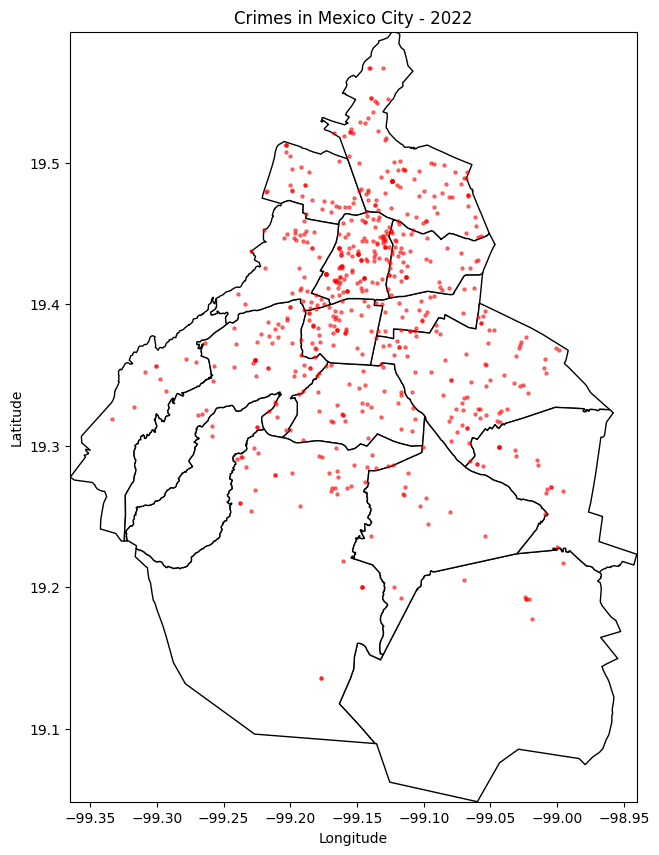

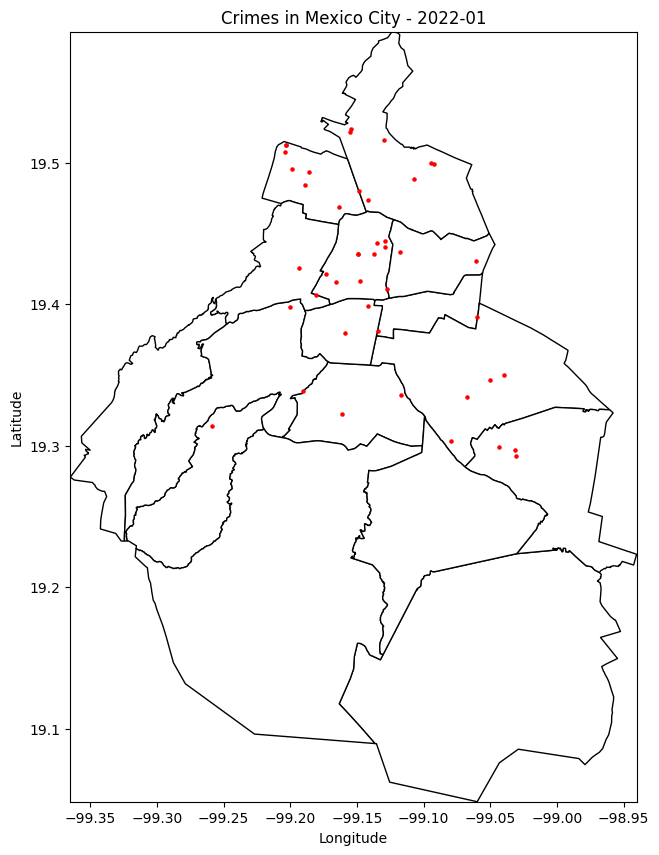

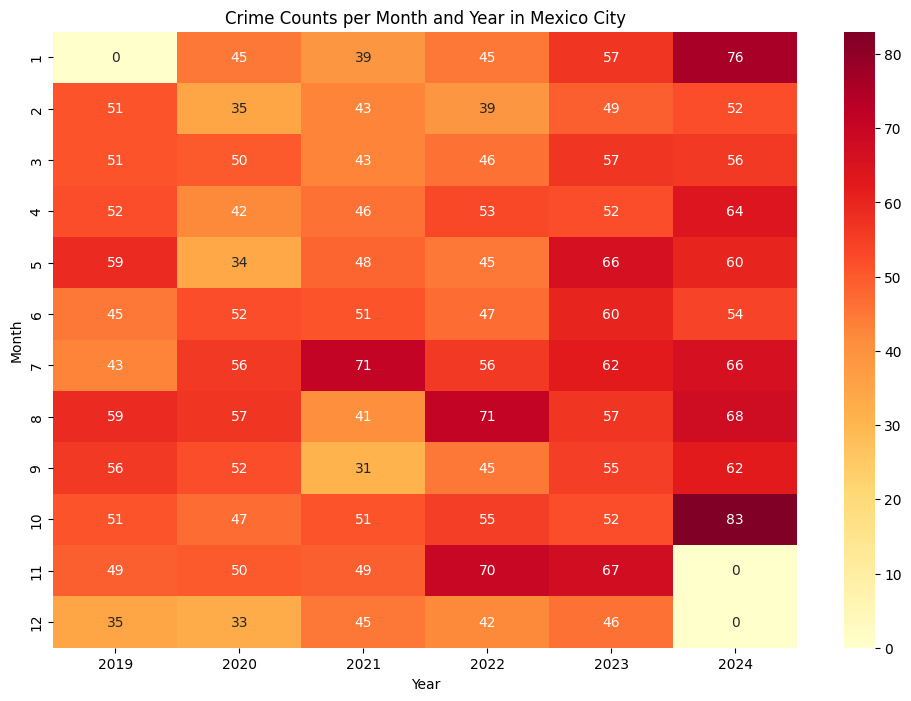

In [31]:
# Function to plot crimes per year
def plot_crimes_by_year(gdf, year):
    # Filter data for the specified year
    gdf_filtered = gdf[gdf['year'] == year]

    if gdf_filtered.empty:
        print(f"No crime data available for {year}.")
        return

    # Ensure both GeoDataFrames are in the same CRS
    if gdf_filtered.crs != city_map.crs:
        gdf_filtered = gdf_filtered.to_crs(city_map.crs)

    # Clip the crime data to the city map extent
    gdf_clipped = gpd.clip(gdf_filtered, city_map)

    if gdf_clipped.empty:
        print(f"No crime data within the city boundaries for {year}.")
        return

    # Plot the city map and crime locations
    fig, ax = plt.subplots(figsize=(10, 10))
    city_map.plot(ax=ax, color='white', edgecolor='black')
    gdf_clipped.plot(ax=ax, marker='o', color='red', markersize=5, alpha=0.5)

    # Set the axis limits to match the city map
    ax.set_xlim(city_map.total_bounds[[0, 2]])
    ax.set_ylim(city_map.total_bounds[[1, 3]])

    plt.title(f'Crimes in Mexico City - {year}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# Function to plot crimes per month and year
def plot_crimes_by_month_year(gdf, year, month):
    # Filter data for the specified year and month
    gdf_filtered = gdf[(gdf['year'] == year) & (gdf['month'] == month)]

    if gdf_filtered.empty:
        print(f"No crime data available for {year}-{month:02d}.")
        return

    # Ensure both GeoDataFrames are in the same CRS
    if gdf_filtered.crs != city_map.crs:
        gdf_filtered = gdf_filtered.to_crs(city_map.crs)

    # Clip the crime data to the city map extent
    gdf_clipped = gpd.clip(gdf_filtered, city_map)

    if gdf_clipped.empty:
        print(f"No crime data within the city boundaries for {year}-{month:02d}.")
        return

    # Plot the city map and crime locations
    fig, ax = plt.subplots(figsize=(10, 10))
    city_map.plot(ax=ax, color='white', edgecolor='black')
    gdf_clipped.plot(ax=ax, marker='o', color='red', markersize=5)

    # Set the axis limits to match the city map
    ax.set_xlim(city_map.total_bounds[[0, 2]])
    ax.set_ylim(city_map.total_bounds[[1, 3]])

    plt.title(f'Crimes in Mexico City - {year}-{month:02d}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# Function to create a heatmap of crime counts per month and year
def plot_crime_heatmap(gdf):
    crime_counts = gdf.groupby(['year', 'month']).size().reset_index(name='counts')
    crime_counts_pivot = crime_counts.pivot(index='month', columns='year', values='counts')

    # Convert the values in crime_counts_pivot to integers, filling NaNs with 0
    crime_counts_pivot = crime_counts_pivot.fillna(0).astype(int)

    plt.figure(figsize=(12, 8))
    sns.heatmap(crime_counts_pivot, annot=True, fmt="d", cmap="YlOrRd")
    plt.title('Crime Counts per Month and Year in Mexico City')
    plt.ylabel('Month')
    plt.xlabel('Year')
    plt.show()

# Example usage:
# Plot crimes for the year 2022
plot_crimes_by_year(gdf_scraping, 2022)

# Plot crimes for January 2022
plot_crimes_by_month_year(gdf_scraping, 2022, 1)

# Plot heatmap of crime counts
plot_crime_heatmap(gdf_scraping)